In [3]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim import corpora, models
from datetime import datetime
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.chunk import conlltags2tree, tree2conlltags, ne_chunk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

dream_path = "dreams/1_05_02_2020.txt"
with open(dream_path, "r") as file:
    dream = file.read().replace('\n', '')

[nltk_data] Downloading package punkt to /Users/asi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/asi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/asi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
dream

'I dreamt that I was floating down a river, grey with glacial silt, through a beautiful mountain valley, with some fairly uninhabited farm land around. It was fun, like recreational tubing. I was with some of my family members and I think Joe Rogan. We floated by a peaceful looking fawn foraging in the brush. shortly after, wolves ran out from the fields. We were all scared they would hurt us and they looked mean. We picked up rocks and to throw at the wolves. Fortunately, we realized the wolves wouldnt come into the water, so we were safe. However, we noticed dogs from a nearby ranch were swimming down the river to hurt us. My aunt had a baseball bat and she gave it to me and I hit and attacked the dogs.'

### initiate dream_dict

In [5]:
### dream data will be stored in dream_dict
def initiate_dream_dict(path):
    
    dream_path = path
    with open(dream_path, "r") as file:
        dream = file.read().replace('\n', '')
    date = datetime.today().strftime('%Y-%m-%d')
    dream_dict = {}
    dream_dict['date'] = date
    dream_dict['dream_original'] = dream
    
    return dream_dict

dream_dict = initiate_dream_dict("dreams/1_05_02_2020.txt")

In [6]:
dream_dict

{'date': '2020-07-01',
 'dream_original': 'I dreamt that I was floating down a river, grey with glacial silt, through a beautiful mountain valley, with some fairly uninhabited farm land around. It was fun, like recreational tubing. I was with some of my family members and I think Joe Rogan. We floated by a peaceful looking fawn foraging in the brush. shortly after, wolves ran out from the fields. We were all scared they would hurt us and they looked mean. We picked up rocks and to throw at the wolves. Fortunately, we realized the wolves wouldnt come into the water, so we were safe. However, we noticed dogs from a nearby ranch were swimming down the river to hurt us. My aunt had a baseball bat and she gave it to me and I hit and attacked the dogs.'}

### text preprocessing

In [7]:
def preprocess_text(text):
    '''This function takes in a list of strings and performs a variety of text preprocessing functions.'''

    text = text.split(' ')
    # remove punctuatiom
    text = [re.sub(r'[^\w\s]', '', x) for x in text]
    # lower case
#     text = [x.lower() for x in text]
    # remove numbers
    text = [re.sub(r'\d+', '', x) for x in text]
    # remove newlines '/n'
    text = [re.sub('\s+', ' ', x) for x in text]
    # remove non-ASCII characters
    text = [re.sub(r'[^\x00-\x7f]',r' ',x) for x in text]
    # remove underscores
    text = [re.sub(r'[_]', '', x) for x in text]

    return text

def remove_stopwords(text):

    stop_words = stopwords.words('english')
    new_stop_words = ['dream', 'dreamed', 'dreamt']
    stop_words.extend(new_stop_words)

    trimmed_words = []
    for i in text:
        if i not in stop_words:
            trimmed_words.append(i)

    return trimmed_words


def get_entities(text):
    
    sentence = ' '.join(text)
    output = tree2conlltags(ne_chunk(pos_tag(word_tokenize(sentence))))
    df = pd.DataFrame(output, columns=['word', 'pos', 'entity'])
    
    return df

def stem_words(df):

    stemmed_text = []
    stemmer = SnowballStemmer("english")
    stemmed_word = stemmer.stem(df.word)

    return stemmed_word

def process(dream_dict):

    dream = dream_dict['dream_original']
    clean_dream = remove_stopwords(preprocess_text(dream))
    df = get_entities(clean_dream)
    df['stemmed_words'] = df.apply(stem_words, axis=1)
    dream_dict['dream_cleaned_as_df'] = df
    
    return dream_dict

dream_dict = process(dream_dict)

In [8]:
dream_dict

{'date': '2020-07-01',
 'dream_original': 'I dreamt that I was floating down a river, grey with glacial silt, through a beautiful mountain valley, with some fairly uninhabited farm land around. It was fun, like recreational tubing. I was with some of my family members and I think Joe Rogan. We floated by a peaceful looking fawn foraging in the brush. shortly after, wolves ran out from the fields. We were all scared they would hurt us and they looked mean. We picked up rocks and to throw at the wolves. Fortunately, we realized the wolves wouldnt come into the water, so we were safe. However, we noticed dogs from a nearby ranch were swimming down the river to hurt us. My aunt had a baseball bat and she gave it to me and I hit and attacked the dogs.',
 'dream_cleaned_as_df':         word  pos entity stemmed_words
 0          I  PRP      O             i
 1          I  PRP      O             i
 2   floating  VBG      O         float
 3      river   NN      O         river
 4       grey  VBP

### Finding People
- Defining the people in your dream may improve understanding
- Words could appear on screen as buttons

In [9]:
def find_people(dream_dict):
    
    family_list = [
        'mom',
        'dad',
        'mother',
        'father',
        'brother',
        'sister',
        'grandfather',
        'grandmother',
        'grandpa',
        'grandma',
        'cousin',
        'aunt',
        'uncle',
        'auntie'
    ]
    
    df = dream_dict['dream_cleaned_as_df']
    people = []
    
    for index, row in df.iterrows():

        if row.entity == 'I-PERSON' or row.entity == 'B-PERSON':
            people.append(row.word)
        if row.word in family_list:
            people.append(row.word)
    
    if people:
        print('These people were in your dream, are they important to you in any way?')
        print([x for x in people if x])
        other_people = (input('If there were other people in your dream that were not found, enter them here: '))
        if other_people != '':
            people.append(other_people)
    else:
        other_people = (input('If there were people in your dream that were not found, enter them here: '))
        if other_people != '':
            people.append(other_people)

    dream_dict['important_people'] = people
    
    return dream_dict

dream_dict = find_people(dream_dict)

These people were in your dream, are they important to you in any way?
['Joe', 'Rogan', 'aunt']
If there were other people in your dream that were not found, enter them here: 


### Processing nouns
- Nouns may describe important *symbols* in the dream.
- Words could appear on screen as buttons

In [10]:
def find_nouns(dream_dict):
    
    df = dream_dict['dream_cleaned_as_df']
    nouns = df[df.pos == 'NN'].word.to_list()
    nouns_ = df[df.pos == 'NNS'].word.to_list()
    nouns = nouns + nouns_
    nouns = set(nouns)
    print('Do any of these things stand out to you as important?')
    print(nouns)
    important_nouns = input('If so, which ones? Pick three: \n')
    important_nouns = important_nouns.split(',')
    print('What do these things mean to you?')
    dream_dict['important_nouns'] = important_nouns
    
    return dream_dict

dream_dict = find_nouns(dream_dict)

Do any of these things stand out to you as important?
{'water', 'river', 'dogs', 'baseball', 'wolves', 'farm', 'members', 'silt', 'aunt', 'brush', 'mountain', 'land', 'fields', 'mean', 'bat', 'rocks', 'tubing', 'family', 'fawn'}
If so, which ones? Pick three: 

What do these things mean to you?


### Processing verbs:
- Verbs might describe the main events or calls to action in the dream
- - Words could appear on screen as buttons

In [11]:
def find_verbs(dream_dict):

    df = dream_dict['dream_cleaned_as_df']
    verbs = df[df.pos == 'VBD'].word.to_list()
    verbs_ = df[df.pos == 'VBP'].word.to_list()
    verbs__ = df[df.pos == 'VBG'].word.to_list()
    verbs___ = df[df.pos == 'VBN'].word.to_list()
    verbs = verbs + verbs_ + verbs__ + verbs___
    verbs = set(verbs)

    print(verbs)
    important_verbs = input('Do any of these actions stand out to you as important?\n If so, which ones? Pick three \n')
    important_verbs = important_verbs.split(',')
    print(f'Does these actions have any significance to you?')
    dream_dict['important_verbs'] = important_verbs 
    
    return dream_dict

dream_dict = find_verbs(dream_dict)

{'picked', 'hurt', 'foraging', 'scared', 'hit', 'realized', 'valley', 'floating', 'wouldnt', 'looking', 'think', 'gave', 'swimming', 'grey', 'floated', 'throw'}
Do any of these actions stand out to you as important?
 If so, which ones? Pick three 

Does these actions have any significance to you?


### Processing advectives: 
- Adjectives might capture the *feeling* of the dream.
- Words could appear on screen as buttons

In [12]:
def find_adjectives(dream_dict):
    
    df = dream_dict['dream_cleaned_as_df']
    adjectives = df[df.pos == 'JJ'].word.to_list()
    adjectives = set(adjectives)

    print('These words might describe the feeling of your dream, do any stand out?')
    print(set(adjectives))
    important_adjectives = input('If so, which ones? Pick three: ')
    important_adjectives = important_adjectives.split(',')
    dream_dict['important_adjectives'] = important_adjectives
    
    return dream_dict

dream_dict = find_adjectives(dream_dict)

These words might describe the feeling of your dream, do any stand out?
{'come', 'noticed', 'recreational', 'glacial', 'safe', 'ranch', 'looked', 'peaceful', 'attacked', 'beautiful', 'uninhabited', 'ran'}
If so, which ones? Pick three: 


In [22]:
def important_words(dream_dict):
    ip_ = dream_dict['important_people']
    in_ = dream_dict['important_nouns']
    iv_ = dream_dict['important_verbs']
    ia_ = dream_dict['important_adjectives']
    important_words = ip_ + in_ + iv_ + ia_ 
    dream_dict['important_words'] = important_words
    
    return dream_dict

dream_dict = important_words(dream_dict)


### dream_dictionary for 1 dream

In [23]:
dream_dict

{'date': '2020-07-01',
 'dream_original': 'I was in the reddish brown desert of Utah or Colorado on a hill side with large rocks everywhere. It was very crowded and appeard to be a mining operation. Below, an impressive array of dynamite was set off the the explosion was orderly, loud, and exciting. Shortly after, a rock slide started. It started below me and I watched from safety. It was very large and many huge rocks fell. It looked like people were getting injured. As I noticed that, I looked up and saw the rock slide starting above me. I hid under the steep face of a small cliff and was protected. Every once in a while I would look up, only to have a massive rock fly right by my head and I would duck again. This went on for some time until someone shouted the rocks had stopped. They pointed out a road to the top of the hill and we climbed it to safety. We had to run but I was worried about a calf injury I had in real life, but it was fine. At the top, there were many people and wel

### Create corpus from dream directory

In [68]:
import glob
dream_paths = glob.glob('dreams/*')

list_of_dream_dicts = []
for dream in dream_paths:
    dream_dict = initiate_dream_dict(dream)
    print(dream_dict['dream_original'])
    dream_dict = process(dream_dict)
    dream_dict = find_people(dream_dict)
    dream_dict = find_nouns(dream_dict)
    dream_dict = find_verbs(dream_dict)
    dream_dict = find_adjectives(dream_dict)
    list_of_dream_dicts.append(dream_dict)
    

I was running away from something that I do not remember, only knowing that I was in danger. I was hitch hiking and got a ride from a man in an old truck. We drove for a long time until we got to a fork in the road. I asked him if this is where the chimera zone was, pointing to the steep hill of a road straight through the intersection. He said yes and with fear, told me that I shouldnt go in there because it was very dangerous. No one who went in came out he said. I knew this and was okay with it, for it was preferred over being caught by the group chasing me. I got out and ran across the road and climbed the hill to get in. It didn't look steep, but the road was so steep that I had to climb by grabbing the pushes as handholds on the side. When I climbed to the top, the road was so steep and the decline on the other side was so steep that I was able to straddle the top. I sat at the top with legs over both sides, took a final look at he concerned man who helped me, and then swung my l

If so, which ones? Pick three: 
hill, cliff, desert, rocks, dynamite, slide, river
What do these things mean to you?
{'crowded', 'shouted', 'fell', 'worried', 'volunteered', 'looked', 'stopped', 'frightening', 'hesitated', 'reddish', 'protected', 'hid', 'getting', 'watched', 'climbed', 'knowing', 'invited', 'starting', 'hannah', 'went', 'happening', 'joined', 'set', 'started', 'noticed', 'mining', 'swam', 'pointed', 'run', 'exciting', 'organized'}
Do any of these actions stand out to you as important?
 If so, which ones? Pick three 
explosion, protected, climbed, ran, crowded, hidden
Does these actions have any significance to you?
These words might describe the feeling of your dream, do any stand out?
{'real', 'next', 'impressive', 'saw', 'safe', 'huge', 'many', 'brown', 'calf', 'middle', 'steep', 'sadie', 'massive', 'injured', 'due', 'small', 'great', 'orderly', 'loose', 'loud', 'top', 'large', 'ultramarathon'}
If so, which ones? Pick three: impressive, huge, red, loud, injured


# Find most similar dream to new dream in corpus
- This works well. I entered a sanity check dream that should obviously fit into dream [1], and it does!

In [70]:
def create_tfidf(corpus):

    # create corpus of dreams
    raw_text_list = []
    cleaned_text_list = []
    for dictionary in corpus:
        
        raw = dictionary['dream_original']
        raw_text_list.append(raw)
        d = dictionary['dream_cleaned_as_df']
        text = d.stemmed_words.to_list()
        text = ' '.join(text)
        cleaned_text_list.append(text)

    vectorizer = TfidfVectorizer()
    docs_tfidf = vectorizer.fit_transform(cleaned_text_list)

    return vectorizer, docs_tfidf, raw_text_list
    
vectorizer, docs_tfidf, raw_text_list = create_tfidf(list_of_dream_dicts)

def get_tf_idf_query_similarity(vectorizer, docs_tfidf, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    def process(query):

        dream = query
        clean_dream = remove_stopwords(preprocess_text(dream))
        df = get_entities(clean_dream)
        df['stemmed_words'] = df.apply(stem_words, axis=1)
        cleaned_query = df['stemmed_words'].to_list()
        cleaned_query = ([' '.join(cleaned_query)])

        return cleaned_query
    
    cleaned_query = process(query)
    query_tfidf = vectorizer.transform(cleaned_query)
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    
    top_prediction = int(np.where(cosineSimilarities == np.amax(cosineSimilarities))[0])
    most_similar_dream = raw_text_list[top_prediction]
    print('Most similar dream in the corpus is: \n')
    
    return most_similar_dream

get_tf_idf_query_similarity(vectorizer, docs_tfidf, 'i was floating down a river and some wolves')

Most similar dream in the corpus is: 



'I dreamt that I was floating down a river, grey with glacial silt, through a beautiful mountain valley, with some fairly uninhabited farm land around. It was fun, like recreational tubing. I was with some of my family members and I think Joe Rogan. We floated by a peaceful looking fawn foraging in the brush. shortly after, wolves ran out from the fields. We were all scared they would hurt us and they looked mean. We picked up rocks and to throw at the wolves. Fortunately, we realized the wolves wouldnt come into the water, so we were safe. However, we noticed dogs from a nearby ranch were swimming down the river to hurt us. My aunt had a baseball bat and she gave it to me and I hit and attacked the dogs.'

In [72]:
list_of_dream_dicts

[{'date': '2020-07-01',
  'dream_original': "I was running away from something that I do not remember, only knowing that I was in danger. I was hitch hiking and got a ride from a man in an old truck. We drove for a long time until we got to a fork in the road. I asked him if this is where the chimera zone was, pointing to the steep hill of a road straight through the intersection. He said yes and with fear, told me that I shouldnt go in there because it was very dangerous. No one who went in came out he said. I knew this and was okay with it, for it was preferred over being caught by the group chasing me. I got out and ran across the road and climbed the hill to get in. It didn't look steep, but the road was so steep that I had to climb by grabbing the pushes as handholds on the side. When I climbed to the top, the road was so steep and the decline on the other side was so steep that I was able to straddle the top. I sat at the top with legs over both sides, took a final look at he con

# Visualize important words per dream
- An intuitive and cheap way (for human recall) to store dream content is in an image, like a wordcloud
- With a quick glance, the dreamer can be reminded of their dream
- Content of wordcloud is based on important people, things, actions and feelings that were self-reported per dream

['Joe', 'Rogan', 'aunt', 'Joe Rogan, aunt', 'wolves', ' river', ' farm', ' fawn', ' baseball bat', ' family', 'swimming', ' foraging', ' hitting', ' throwing', 'safe', ' peaceful', ' beautiful', ' uninhibited', ' scared']


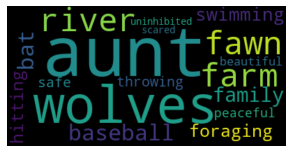

['aunt', 'mom', 'grandmother', 'birch', ' paper', ' barn', ' catkin', ' poem', ' marriage', 'wedding', ' embarrassed', ' trampled', ' obliged', ' writing', ' ignored', 'rustic', ' western', ' worn']


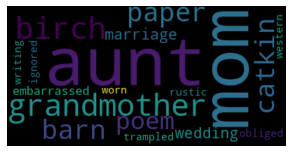

['Utah', 'Colorado', 'hill', ' cliff', ' desert', ' rocks', ' dynamite', ' slide', ' river', 'explosion', ' protected', ' climbed', ' ran', ' crowded', ' hidden', 'impressive', ' huge', ' red', ' loud', ' injured']


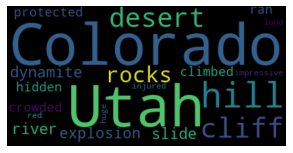

In [75]:
# not sure the best way to use these yet, but could probs do some cool stuff with important people, nouns, verbs, etc.
for i in list_of_dream_dicts[1:]:
#     print(i['dream_original'])
    i = important_words(i)
    
    print(i['important_words'])
    
    text = i['important_words']
    text = ' '.join(text)
    text = text.replace('Joe Rogan', '')
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    plt.figure(figsize=(5,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()    

# LDA
- LDA will be used for topic modeling. Once the database is populated with enough dreams, topics may be able to be determined.
- With these topics, dreams can be sorted into categories and new dreams can be appropriately fit into a category.
- This can be ignored for awhile, need sufficient dreams for it to be interesting.

In [31]:
# create corpus of dreams
text_list = []
for dictionary in list_of_dream_dicts:
    d = dictionary['dream_cleaned_as_df']
    text = d.stemmed_words.to_list()
    text_list.append(text)

In [32]:
# create word frequency dictionary
dictionary = gensim.corpora.Dictionary(text_list)
# create bag-of-words representation of corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in text_list]
# create tf-idf model object
tfidf = models.TfidfModel(bow_corpus)
# transform entire corpus with tf-idf
corpus_tfidf = tfidf[bow_corpus]

# create LDA model from bow_corpus
# determine number of topics
num_topics = 5
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)

In [33]:
# print LDA topics found in corpus
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.004*"read" + 0.004*"wolv" + 0.004*"road" + 0.004*"steep" + 0.004*"rock" + 0.004*"hurt" + 0.004*"float" + 0.004*"my" + 0.004*"would" + 0.004*"dog"
Topic: 1 Word: 0.008*"wolv" + 0.007*"steep" + 0.007*"road" + 0.006*"us" + 0.006*"hurt" + 0.006*"dog" + 0.006*"float" + 0.006*"danger" + 0.006*"said" + 0.006*"chimera"
Topic: 2 Word: 0.004*"wolv" + 0.004*"felt" + 0.004*"steep" + 0.004*"read" + 0.004*"road" + 0.004*"rock" + 0.004*"float" + 0.004*"peopl" + 0.004*"got" + 0.004*"would"
Topic: 3 Word: 0.008*"read" + 0.007*"everyon" + 0.007*"birch" + 0.007*"catkin" + 0.007*"marri" + 0.007*"cousin" + 0.007*"love" + 0.007*"poem" + 0.007*"done" + 0.007*"embarrass"
Topic: 4 Word: 0.007*"rock" + 0.007*"safeti" + 0.007*"start" + 0.007*"log" + 0.007*"peopl" + 0.006*"would" + 0.006*"at" + 0.006*"join" + 0.006*"slide" + 0.006*"mani"


# Predict the topic of a new dream
### Process dream

In [34]:
def initiate_dream_dict_direct(dream):
    
    date = datetime.today().strftime('%Y-%m-%d')
    dream_dict = {}
    dream_dict['date'] = date
    dream_dict['dream_original'] = dream
    
    return dream_dict

new_dream = 'I was in my home city and right by the water when tidal waves started crashing over the streets. I climbed to the top of a tree and held on as tight as I could but the waves continued crashing and I saw many people swalled up in the current. When there was a break in the waves, I jumped down and swam to shore, where I climbed up a bridge and ran away. Once I was safe, my vantage point zoomed out to space where I saw one big wave crash over the whole pacific coast and to my surprise, went over the cascades, across the rockies, great plains, appalachians, and eventually into the atlantic ocean. The whole country was submerged in water.'
new_dream_dict = initiate_dream_dict_direct(new_dream)
print(new_dream_dict['dream_original'])
new_dream_dict = process(new_dream_dict)
new_dream_dict = find_people(new_dream_dict)
new_dream_dict = find_nouns(new_dream_dict)
new_dream_dict = find_verbs(new_dream_dict)
new_dream_dict = find_adjectives(new_dream_dict)
new_processed_dream = new_dream_dict['dream_cleaned_as_df']

I was in my home city and right by the water when tidal waves started crashing over the streets. I climbed to the top of a tree and held on as tight as I could but the waves continued crashing and I saw many people swalled up in the current. When there was a break in the waves, I jumped down and swam to shore, where I climbed up a bridge and ran away. Once I was safe, my vantage point zoomed out to space where I saw one big wave crash over the whole pacific coast and to my surprise, went over the cascades, across the rockies, great plains, appalachians, and eventually into the atlantic ocean. The whole country was submerged in water.
If there were people in your dream that were not found, enter them here: 
Do any of these things stand out to you as important?
{'vantage', 'bridge', 'point', 'appalachians', 'surprise', 'streets', 'tree', 'water', 'coast', 'people', 'shore', 'plains', 'crash', 'break', 'space', 'rockies', 'swam', 'pacific', 'city', 'waves', 'cascades', 'wave', 'country'}


### Predict dream topic in LDA model
- This will be useless until more dreams are gathered

In [35]:
# feed preprocessed dream into LDA model
new_dictionary = gensim.corpora.Dictionary([new_processed_dream])
new_bow_vector = new_dictionary.doc2bow(new_processed_dream)
for index, score in sorted(lda_model_tfidf[new_bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

Score: 0.8379603624343872	 Topic: 0.008*"wolv" + 0.007*"steep" + 0.007*"road" + 0.006*"us" + 0.006*"hurt"
Score: 0.04089013487100601	 Topic: 0.008*"read" + 0.007*"everyon" + 0.007*"birch" + 0.007*"catkin" + 0.007*"marri"
Score: 0.04040268436074257	 Topic: 0.004*"wolv" + 0.004*"felt" + 0.004*"steep" + 0.004*"read" + 0.004*"road"
Score: 0.040402647107839584	 Topic: 0.004*"read" + 0.004*"wolv" + 0.004*"road" + 0.004*"steep" + 0.004*"rock"
Score: 0.04034410044550896	 Topic: 0.007*"rock" + 0.007*"safeti" + 0.007*"start" + 0.007*"log" + 0.007*"peopl"


### Playing with charts...

In [140]:
rand = [22, 10, 13, 21, 4, 16, 21, 28, 13, 5, 11, 21]
d = pd.DataFrame(rand)
rate = sum(rand)/365
rate

0.5068493150684932

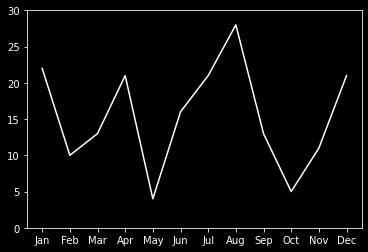

<Figure size 2880x2880 with 0 Axes>

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

plt.style.use('dark_background')


# dummy data (Days)
dates_d = pd.date_range('2010-01-01', '2010-12-31', freq='D')
df_year = pd.DataFrame(np.random.randint(1, 2, (dates_d.shape[0], 1)), columns=['Data'])
df_year.index = dates_d #set index

# pt = pd.pivot_table(df_year, index=df_year.index.month, columns=df_year.index.year, aggfunc='sum')
# pt.columns = pt.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

ax = plt.figure().add_subplot(111)

ax.plot(d, color='w')

ticklabels = [datetime.date(1900, item, 1).strftime('%b') for item in pt.index]
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(ticklabels) #add monthlabels to the xaxis
ax.set_yticks(np.arange(0,31, 5))

# ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.

plt.figure(figsize=(40,40))
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show();

In [143]:
rand = [1, 0, 1, 0, 0, 0, 1, 0, 1, 1,1, 0, 1, 0, 0, 0, 1, 0, 1, 1,1, 0, 1, 0, 0, 0, 1, 0, 1, 1]

rand = [7, 2, 5, 4]
d = pd.DataFrame(rand)
rate = sum(rand)/30
rate

0.6

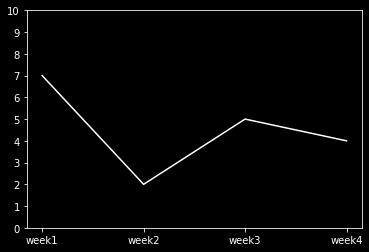

<Figure size 2880x2880 with 0 Axes>

In [131]:
plt.style.use('dark_background')


# dummy data (Days)
dates_d = pd.date_range('2010-01-01', '2010-01-31', freq='D')
df_year = pd.DataFrame(np.random.randint(1, 2, (dates_d.shape[0], 1)), columns=['Data'])
df_year.index = dates_d #set index

# pt = pd.pivot_table(df_year, index=df_year.index.month, columns=df_year.index.year, aggfunc='sum')
# pt.columns = pt.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

ax = plt.figure().add_subplot(111)

ax.plot(d, color='w')

ticklabels = [datetime.date(1900, item, 1).strftime('%b') for item in pt.index]
ax.set_xticks(np.arange(0,4))
ax.set_xticklabels(['week1', 'week2', 'week3', 'week4']) #add monthlabels to the xaxis
ax.set_yticks(np.arange(0,11))


# ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.

plt.figure(figsize=(40,40))
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show();

In [144]:
rand = [0, 1, 1, 1, 0, 0, 1]
d = pd.DataFrame(rand)
rate = sum(rand)/7
rate

0.5714285714285714

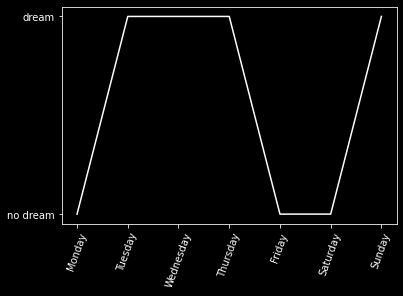

<Figure size 2880x2880 with 0 Axes>

In [138]:
plt.style.use('dark_background')


# dummy data (Days)
dates_d = pd.date_range('2010-01-01', '2010-01-31', freq='D')
df_year = pd.DataFrame(np.random.randint(1, 2, (dates_d.shape[0], 1)), columns=['Data'])
df_year.index = dates_d #set index

# pt = pd.pivot_table(df_year, index=df_year.index.month, columns=df_year.index.year, aggfunc='sum')
# pt.columns = pt.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

ax = plt.figure().add_subplot(111)

ax.plot(d, color='w')

ticklabels = [datetime.date(1900, item, 1).strftime('%b') for item in pt.index]
ax.set_xticks(np.arange(0,7),)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']) #add monthlabels to the xaxis
ax.set_yticks(np.arange(0,2))
ax.set_yticklabels(['no dream', 'dream'])

# ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.
plt.xticks(rotation=70)
plt.figure(figsize=(40,40))
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show();

explained variance ratio (first two components): [0.92461872 0.05306648]


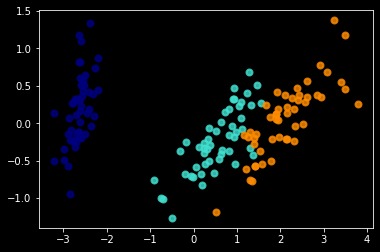

In [155]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)


# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)




plt.show()
